# Simple modeling for explanatory purposes

In [1]:
import numpy as np 
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from yellowbrick.regressor import residuals_plot, prediction_error
from fast_ml.model_development import train_valid_test_split
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from tpot import TPOTRegressor
import category_encoders as ce
import time
from xgboost import XGBRegressor
import warnings
encoders = {

    'BackwardDifferenceEncoder': ce.backward_difference.BackwardDifferenceEncoder,
    'OneHotEncoder': ce.one_hot.OneHotEncoder,
    
}


In [2]:
import os 
os.chdir('..')
from Utils.Metrics import regression as reg_metrics
os.chdir('./9. Clickstream data for online shopping')

In [3]:
clothing_data_df = pd.read_csv('./data/e-shop data and description/e-shop clothing 2008.csv',sep=',').drop(['Unnamed: 0'],axis=1)

<AxesSubplot:>

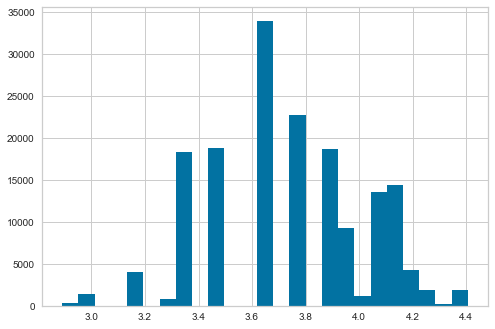

In [4]:
clothing_data_df.price.apply(np.log).hist(bins=25)

In [4]:
# define results
results_df = pd.DataFrame(columns = ['model','rmse','r2','mape'])

In [5]:
# many levels can't be one-hot encoded - use encoder for these
max_levels = round(clothing_data_df.columns.shape[0]*0.5)
categorical_features = clothing_data_df.select_dtypes(exclude=[np.number]).columns
cats_many = []
cats_few = []
for ft in categorical_features:
    levels = clothing_data_df[ft].unique().shape[0]
    if levels > max_levels:
        cats_many.append(ft)
    else:
        cats_few.append(ft)

In [6]:
# definitions
numeric_features = clothing_data_df.select_dtypes([np.number]).drop(['price'], axis=1).columns
numeric_features

categorical_features = clothing_data_df.select_dtypes(exclude=[np.number]).columns
categorical_features

X = clothing_data_df.drop('price', axis=1)
y = clothing_data_df['price']

y = np.log(y)

X_train, X_test_tmp, y_train, y_test_tmp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test_tmp, y_test_tmp, test_size=0.5)

del X_test_tmp, y_test_tmp


In [ ]:
# first model
selected_model = XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0)

In [ ]:
# define pipeline using BackwardDifferenceEncoder for categorical

categorical_transformer_many_level = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', encoders['BackwardDifferenceEncoder']())
    ]
)    

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', encoders['OneHotEncoder']())
    ]
) 

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric_features),
        ('categorical_many', categorical_transformer_many_level, cats_many),
        ('categorical', categorical_transformer, cats_few)
    ]
)

pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', selected_model)
    ]
)


In [7]:
# feature names for feature importances etc etc
pipe.named_steps['preprocessor'].fit(X_train)

numeric_feat_names = pipe.named_steps['preprocessor'].transformers_[0][2]
cat_feat_names = pipe.named_steps['preprocessor'].transformers_[1][2]    
feature_names = list(numeric_feat_names) + list(cat_feat_names) 

## BASLINE

In [8]:
pred = [y_train.mean()]*len(y_val)
pred = np.exp(pred)
y_val_s = np.exp(y_val)
res_row_obj = reg_metrics.calc_results(pred, y_val_s,'Baseline')
row = res_row_obj.calc_results_row()
results_df = results_df.append(row,ignore_index=True)
results_df

,model,rmse,r2,mape
0,Baseline,12.650522,-7.924584e+29,23.99252


## XGB defaults

In [9]:
preprocessor.fit(X_train, y_train)
X_train_prc = preprocessor.transform(X_train)
X_val_prc = preprocessor.transform(X_val)
X_test_prc = preprocessor.transform(X_test)
evalset = [(X_train_prc, y_train), (X_val_prc,y_val)]
selected_model.fit(X_train_prc, y_train, eval_metric='rmse', eval_set=evalset, verbose=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, single_precision_histogram=True,
             subsample=1, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

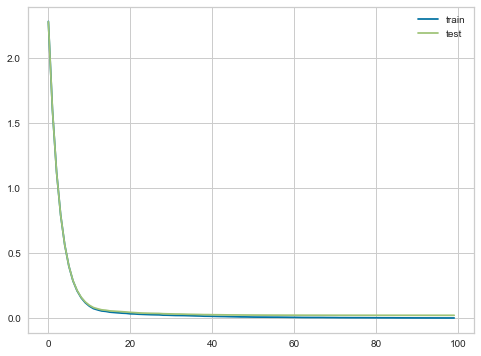

In [17]:
results = selected_model.evals_result()

plt.figure(figsize=(8,6))
# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.show()

In [10]:
pred = selected_model.predict(X_test_prc)
pred = np.exp(pred)
y_val_s = np.exp(y_test)
res_row_obj = reg_metrics.calc_results(pred, y_val_s,'defaults XGBReg')
row = res_row_obj.calc_results_row()
results_df = results_df.append(row,ignore_index=True)
results_df

,model,rmse,r2,mape
0,Baseline,12.650522,-7.924584e+29,23.992520
1,defaults XGBReg,1.773988,9.805227e-01,0.135421


[(0.0, 200.0)]

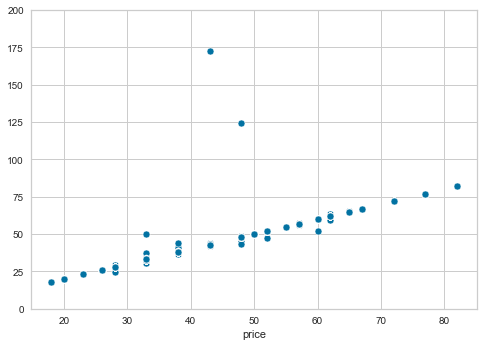

In [26]:
g =sns.scatterplot(y_val_s, pred)
g.set(ylim=(0, 200))


In [28]:
# we have a few weird values being predicted 

pred[pred>100]

array([ 172.32095, 3670.8325 ,  124.40568], dtype=float32)

In [30]:
# do they have some unexpected values?

X_test.iloc[np.where(pred>100)]

,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,page
22727,4,12,2,47,3297,1,A6,3,2,1,1
64025,5,14,1,47,9249,2,B24,11,2,1,2
56958,5,8,161,29,8201,2,B34,2,6,1,2


In [33]:
# country 47 is not a country - it is an 'org' domain 
X_train.country.value_counts()[X_train.country.value_counts().index==47] 

47    3
Name: country, dtype: int64

## BASIC GRIDSEARCH

In [11]:
# BASIC TUNE PARAMS 

start_time=time.time()

# grid search
xgb_reg = XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0)

param_grid = {
        'max_depth': [6, 9, 12],
        'learning_rate': [0.03, 0.05, 0.07],
        'n_estimators':[1500, 1800, 2100],
                               }

kfold = KFold(n_splits=3, shuffle=True, random_state=10)
grid_search = GridSearchCV(xgb_reg, param_grid, scoring="neg_root_mean_squared_error", cv=kfold)
grid_result = grid_search.fit(X_train_prc, y_train, verbose=0)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_[ 'mean_test_score' ]
stds = grid_result.cv_results_[ 'std_test_score' ]
params = grid_result.cv_results_[ 'params' ]

print(time.time()-start_time)

Best: -0.003677 using {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1500}
1219.6475224494934


In [12]:
model = XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0, **grid_result.best_params_)
model.fit(X_train_prc,y_train)
y_pred = model.predict(X_test_prc)

In [13]:
pred = np.exp(y_pred)
y_val_s = np.exp(y_test)
res_row_obj = reg_metrics.calc_results(pred, y_val_s,'GridSearchCV XGBReg')
row = res_row_obj.calc_results_row()
results_df = results_df.append(row,ignore_index=True)
results_df

,model,rmse,r2,mape
0,Baseline,12.650522,-7.924584e+29,23.992520
1,defaults XGBReg,1.773988,9.805227e-01,0.135421
2,GridSearchCV XGBReg,1.228305,9.906251e-01,0.041728


[(0.0, 100.0)]

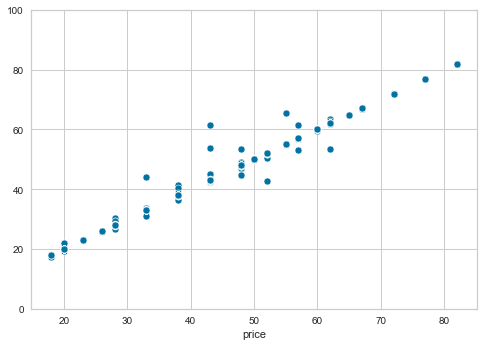

In [41]:
g =sns.scatterplot(y_val_s, pred)
g.set(ylim=(0, 100))

## Tuning with regularization : Hyperopt

In [44]:
space={ 'eta' : 0.03 ,
        'max_depth': hp.uniform("max_depth", 5, 16, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'seed': 0
    }

def objective(space):
   
    clf=XGBRegressor(max_depth = int(space['max_depth']),learning_rate=space['eta'], gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0)
    evaluation = [( X_train_prc, y_train), ( X_val_prc, y_val)]
    
    clf.fit(X_train_prc, y_train,
    eval_set=evaluation, eval_metric="rmse",
    early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test_prc)
    accuracy = np.sqrt(mse(y_test, pred))
    print ("RMSE:", accuracy)
    return {'loss': accuracy, 'status': STATUS_OK }

In [45]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

RMSE:                                                                                                                  
0.3203445949524253                                                                                                     
RMSE:                                                                                                                  
0.31932807379739375                                                                                                    
RMSE:                                                                                                                  
0.32025255945190445                                                                                                    
RMSE:                                                                                                                  
0.3202584028916892                                                                                                     
RMSE:                                   

In [48]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])

In [52]:
best_hyperparams

{'colsample_bytree': 0.7973774904984828,
 'gamma': 4.4761102231082655,
 'max_depth': 12,
 'min_child_weight': 3.0,
 'reg_alpha': 40.0,
 'reg_lambda': 0.8393155775720642}

In [49]:
model = XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0, **best_hyperparams)
model.fit(X_train_prc,y_train)
y_pred = model.predict(X_test_prc)


In [50]:
pred = np.exp(y_pred)
y_val_s = np.exp(y_test)
res_row_obj = reg_metrics.calc_results(pred, y_val_s,'Hyperopt XGBReg')
row = res_row_obj.calc_results_row()
results_df = results_df.append(row,ignore_index=True)
results_df

,model,rmse,r2,mape
0,Baseline,12.671811,-7.951278e+29,24.083353
1,defaults XGBReg,22.958010,2.349962e-01,0.094553
2,GridSearchCV XGBReg,5.353307,8.475657e-01,0.033230
3,Hyperopt XGBReg,4.321674,8.029670e-01,7.810683


In [ ]:
# rmse is lower but mape is higher?

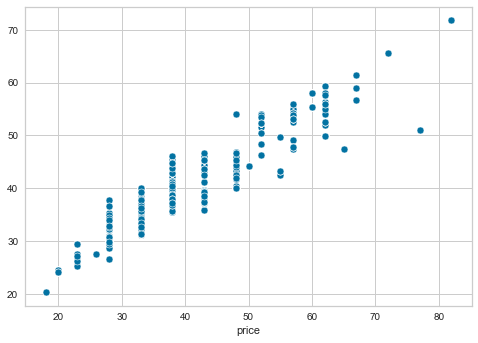

In [51]:
g =sns.scatterplot(y_val_s, pred)
#g.set(ylim=(0, 100))

## COMPARISON ACROSS MODELS USING HYPEROPT

In [ ]:
# https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

I love the way this dude keeps all his stuff so neat

In [61]:
# before 'spacifying' parameter ranges, put these into dict for extraction for learning
# before 'spacifying' parameter ranges, put these into dict for extraction for learning
xgb_choice_params = {
    'learning_rate':    np.arange(0.05, 0.31, 0.05),
    'max_depth':        np.arange(5, 16, 1, dtype=int),
    'min_child_weight': np.arange(1, 8, 1, dtype=int),
    'colsample_bytree': np.arange(0.3, 0.8, 0.1),

}

lgb_choice_params = {
    'learning_rate':    np.arange(0.05, 0.31, 0.05),
    'max_depth':        np.arange(5, 16, 1, dtype=int),
    'min_child_weight': np.arange(1, 8, 1, dtype=int),
    'colsample_bytree': np.arange(0.3, 0.8, 0.1),
}

ctb_choice_params = {
    'learning_rate':     np.arange(0.05, 0.31, 0.05),
    'max_depth':         np.arange(5, 16, 1, dtype=int),
    'colsample_bylevel': np.arange(0.3, 0.8, 0.1),

}

In [27]:
from sklearn.metrics import mean_squared_error


# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     200,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(5, 16, 1, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'n_estimators':      100,
    'eval_metric':       'RMSE',
}
ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


In [17]:
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}


In [29]:
obj = HPOpt(X_train_prc, X_val_prc, y_train, y_val)
# the dataset is not so complex that it needs tones of evals
xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=50)


<bound method HPOpt.xgb_reg of <__main__.HPOpt object at 0x000002389EEE8790>>
100%|██████████████████████████████████████████| 50/50 [2:52:02<00:00, 206.44s/trial, best loss: 5.039651774326599e-05]
<bound method HPOpt.lgb_reg of <__main__.HPOpt object at 0x000002389EEE8790>>
100%|████████████████████████████████████████████| 50/50 [02:16<00:00,  2.74s/trial, best loss: 0.00040253329178474475]
<bound method HPOpt.ctb_reg of <__main__.HPOpt object at 0x000002389EEE8790>>
100%|█████████████████████████████████████████████| 50/50 [33:13<00:00, 39.86s/trial, best loss: 9.554781700581013e-06]


In [78]:
xgb_tuned_params = {x[0]:xgb_choice_params[x[0]][x[1]] if x[0] in xgb_choice_params else x[1] for x in xgb_opt[0].items()}
lgb_tuned_params = {x[0]:lgb_choice_params[x[0]][x[1]] if x[0] in lgb_choice_params else x[1] for x in lgb_opt[0].items()}
ctb_tuned_params = {x[0]:ctb_choice_params[x[0]][x[1]] if x[0] in ctb_choice_params else x[1] for x in ctb_opt[0].items()}

In [80]:
xgb_reg = XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0, **xgb_tuned_params)
xgb_reg.fit(X_train_prc, y_train, eval_set=[(X_train_prc, y_train), (X_val_prc, y_val)],**xgb_para['fit_params'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7000000000000002,
             enable_categorical=False, gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=14, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, single_precision_histogram=True,
             subsample=0.9482814392128229, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [81]:
y_pred = xgb_reg.predict(X_test_prc)
pred = np.exp(y_pred)
y_val_s = np.exp(y_test)
res_row_obj = reg_metrics.calc_results(pred, y_val_s,'Hyperopt XGBReg')
row = res_row_obj.calc_results_row()

In [82]:
results_df = results_df.append(row,ignore_index=True)
results_df

,model,rmse,r2,mape
0,Baseline,12.650522,-7.924584e+29,23.992520
1,defaults XGBReg,1.773988,9.805227e-01,0.135421
2,GridSearchCV XGBReg,1.228305,9.906251e-01,0.041728
3,Hyperopt XGBReg,21.725783,2.558151e-01,0.248813


In [83]:
lgb_reg = lgb.LGBMRegressor(**lgb_tuned_params)
lgb_reg.fit(X_train_prc, y_train, eval_set=[(X_train_prc, y_train), (X_val_prc, y_val)],**lgb_para['fit_params'])
y_pred = lgb_reg.predict(X_test_prc)
pred = np.exp(y_pred)
y_val_s = np.exp(y_test)
res_row_obj = reg_metrics.calc_results(pred, y_val_s,'Hyperopt LGBReg')
row = res_row_obj.calc_results_row()
results_df = results_df.append(row,ignore_index=True)
results_df

,model,rmse,r2,mape
0,Baseline,12.650522,-7.924584e+29,23.992520
1,defaults XGBReg,1.773988,9.805227e-01,0.135421
2,GridSearchCV XGBReg,1.228305,9.906251e-01,0.041728
3,Hyperopt XGBReg,21.725783,2.558151e-01,0.248813
4,Hyperopt LGBReg,0.066331,9.999724e-01,0.016224


In [91]:
ctb_reg = ctb.CatBoostRegressor(**ctb_tuned_params)
ctb_reg.fit(X_train_prc, y_train, eval_set=[(X_train_prc, y_train), (X_val_prc, y_val)],**ctb_para['fit_params'])
y_pred = ctb_reg.predict(X_test_prc)
pred = np.exp(y_pred)
y_val_s = np.exp(y_test)
res_row_obj = reg_metrics.calc_results(pred, y_val_s,'Hyperopt CTBReg')
row = res_row_obj.calc_results_row()
results_df = results_df.append(row,ignore_index=True)
results_df

,model,rmse,r2,mape
0,Baseline,12.650522,-7.924584e+29,23.992520
1,defaults XGBReg,1.773988,9.805227e-01,0.135421
2,GridSearchCV XGBReg,1.228305,9.906251e-01,0.041728
3,Hyperopt XGBReg,21.725783,2.558151e-01,0.248813
4,Hyperopt LGBReg,0.066331,9.999724e-01,0.016224
5,Hyperopt CTBReg,0.001424,1.000000e+00,0.000392


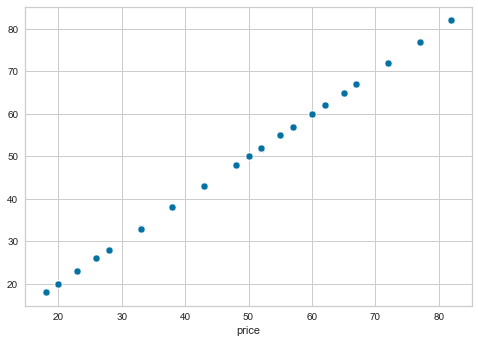

In [93]:
g = sns.scatterplot(y_val_s, pred)

In [95]:
# saving the catboost model as it is by far the best performing
os.chdir('./artifacts')
ctb_reg.save_model('ctb_reg_clickstream.cbm')